# Traffic Sign Classification
***

In this script, I developed a convolutional neural network (CNN) to classify German traffic signs (43 categories). The emphasis of this script is to develop a simple, yet robust model, rather then *very clever* implementation. It can be divided into two parts:

1. **Data perparation:** The images have various sizes, with 53x53 being the average. Therefore, we rescale all images to 52x52 to ensure equal images sizes throughout training. We further rescale the pixel values to be between -1.0 and 1.0 with a mean of 0.0 to improve the learning results. Finally, the images and their one-hot labels are saved and serialised appropriately.

2. **Learning:** The data set is first divided into a training and validation set, and then learning is performed. The network architecture is the following:

    Input(52,52,3)  
    &darr;  
    ConvLayer+ReLU and MaxPooling (26,26,32)  
    &darr;  
    ConvLayer+ReLU and MaxPooling (13,13,64)  
    &darr;  
    ConvLayer+ReLU and MaxPooling (7,7,128)  
    &darr;  
    DenseLayer+ReLU+Dropout(2048)  
    &darr;  
    DenseLayer+ReLU+Dropout(1024)  
    &darr;  
    DenseLayer+SoftMax(43)  
    &darr;  
    Cross-Entropy Loss
    
    We use the [Adam optimizer](https://arxiv.org/abs/1412.6980) which is a variant of the (stochastic) gradient descent algorithm. We train the neural network with a batch size of 128 examples. The classification accuracy on the current batch as well as the held-out validation set is calculated every 50 iterations. After 5000 iterations, which is equivalent to 16 epochs, a classification accuracy of 97% is achieved (compared to 2% at random). 

***
## Additional Remarks

The training data that was used can be downloaded from http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset. 

In [1]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import pickle
from matplotlib import pyplot as plt
from matplotlib import figure
from os import listdir
from os.path import isfile, join
import time
%matplotlib inline

## Image Data and Rescaling

In the first step, we have a quick look at the data and rescale it accordingly.

Dimensions of the image: (30, 29, 3)


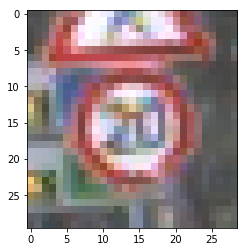

In [2]:
img = cv.imread('Final_Training/Images/00000/00000_00000.ppm', cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
print('Dimensions of the image:', img.shape)
#plt.figure(num=None, figsize=(1, 1))
plt.imshow(img)

Dimensions of the rescaled image: (53, 53, 3)


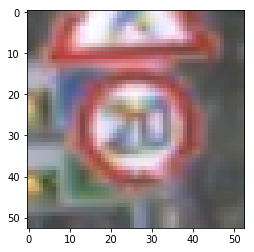

In [3]:
img_rescaled = cv.resize(img, (53,53))
print('Dimensions of the rescaled image:', img_rescaled.shape)
plt.imshow(img_rescaled)

We can have a look what the average size of the images of class 1 are:

In [4]:
cur_path = 'Final_Training/Images/00000/'
files_class1 = [f for f in listdir(cur_path) if isfile(join(cur_path, f))]
dims = np.zeros((len(files_class1), 3))
for i,f in enumerate(files_class1):
    img = cv.imread(join(cur_path, f), cv.IMREAD_COLOR)
    if img is not None:
        dims[i] = img.shape

# Remove error images 
err_imgs = (np.all(dims == 0, axis=1)) # Check where the dimension entry consists of only zeros (0,0,0)
err_imgs_ind = np.arange(len(files_class1))[err_imgs] # Get the indices of theres entries
dims = np.delete(dims, err_imgs_ind, axis=0) # And remove them

print('Average x-dim: ', np.average(dims[:,0]))
print('Average y-dim: ', np.average(dims[:,1]))
print('Average channels: ', np.average(dims[:,2]))    

Average x-dim:  53.857142857142854
Average y-dim:  52.90952380952381
Average channels:  3.0


We can now see that the average size if roughly 53x53, so we will rescale all images to 52x52 (as we can easily devide this number by 2). (We could take the images from the other classses into account as well to achieve a more accurate result)

## Data Import and Serialisation

We now import the whole data set and serialise it appropriately with pickle.

In [5]:
training_path = 'Final_Training/Images'
try:
    train_data = pickle.load(open('train_data.p', 'rb'))
    train_labels = pickle.load(open('train_labels.p', 'rb'))
    print('Data set loaded from files.')
except:
    train_data = np.zeros((40000,52,52,3), dtype=np.float32)
    train_labels = np.zeros((40000, 43), dtype=np.float32)
    i = 0
    for folder in listdir(training_path):
        label = int(folder[-2:])
        cur_path = join(training_path, folder)
        files = [f for f in listdir(cur_path) if isfile(join(cur_path, f))]
        for img in files:
            img = cv.imread(join(cur_path,img), cv.IMREAD_COLOR)
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = cv.resize(img, (52,52))
                train_data[i,:,:,:] = img
                train_labels[i,:] = np.identity(43)[label,:]
                i += 1
    # Get error images
    err_ind = np.arange(40000)[(np.sum(train_data, axis=(1,2,3)) == 0)]
    train_data = np.delete(train_data, err_ind, axis=0)
    train_labels = np.delete(train_labels, err_ind, axis=0)
    assert len(train_labels) == len(train_data)
    print('Length of the training set:', len(train_labels))
    
    #Normalise data
    train_data /= 255.0
    train_data -= 0.5
    
    pickle.dump(train_data, open('train_data.p', 'wb'))
    pickle.dump(train_labels, open('train_labels.p', 'wb'))
    print('Saved to file.')

Data set loaded from files.


In [6]:
# Shuffle training data
p = np.random.permutation(len(train_data))
train_data = train_data[p]
train_labels = train_labels[p]

# Remove a validation set
train_data, val_data = np.split(train_data, [-200])
train_labels, val_labels = np.split(train_labels, [-200])


## Learning

First, we define the network we want to use. In this case, we use the low-level API of tensorflow to ensure maximum control over what is performed.

In [7]:
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32, shape=(None, 52,52,3))
    y = tf.placeholder(tf.float32, shape=(None,43))
    val_x = tf.constant(val_data)

    # Weights
    c1 = tf.Variable(tf.truncated_normal(shape=[3,3,3,32], stddev=0.1))
    b1 = tf.Variable(tf.constant(1.0, shape=[32]))
    c2 = tf.Variable(tf.truncated_normal(shape=[3,3,32,64], stddev=0.1))
    b2 = tf.Variable(tf.constant(1.0, shape=[64]))
    c3 = tf.Variable(tf.truncated_normal(shape=[2,2,64,128], stddev=0.1))
    b3 = tf.Variable(tf.constant(1.0, shape=[128]))
    
    #w1 = tf.Variable(tf.truncated_normal(shape=[7*7*128, 1024], stddev=0.1))
    #b4 = tf.Variable(tf.constant(0.0, shape=[1024]))
    
    w1 = tf.Variable(tf.truncated_normal(shape=[7*7*128, 2048], stddev=0.1))
    b4 = tf.Variable(tf.constant(0.0, shape=[2048]))
    w2 = tf.Variable(tf.truncated_normal(shape=[2048, 1024], stddev=0.1))
    b5 = tf.Variable(tf.constant(0.0, shape=[1024]))
    
    w3 = tf.Variable(tf.truncated_normal(shape=[1024,43], stddev=0.1))
    b6 = tf.Variable(tf.constant(0.0, shape=[43]))


    def cnn_model(x, istrain=False):
    # Conv+Max Pool (52,52,3) -> (26,26,32)
        conv = tf.nn.conv2d(input=x, filter=c1, strides=[1,1,1,1], padding='SAME')
        conv = tf.nn.relu(conv + b1)
        maxp = tf.nn.max_pool(conv, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

        # Conv+Max Pool (26,26,32) -> (13, 13, 64)
        conv2 = tf.nn.conv2d(input=maxp, filter=c2, strides=[1,1,1,1], padding='SAME')
        conv2 = tf.nn.relu(conv2 + b2)
        maxp2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

        # Conv+Max Pool (13, 13, 64) -> (7,7,128)
        conv3 = tf.nn.conv2d(input=maxp2, filter=c3, strides=[1,1,1,1], padding='SAME')
        conv3 = tf.nn.relu(conv3 + b3)
        maxp3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        maxp3 = tf.reshape(maxp3, shape=[-1, 7*7*128])
        
        # Dense Layers
        dl = tf.nn.relu(tf.matmul(maxp3, w1)+b4)
        if istrain:
            dl = tf.nn.dropout(dl, 0.5)
        dl2 = tf.nn.relu(tf.matmul(dl, w2)+b5)
        if istrain:
            dl2 = tf.nn.dropout(dl2,0.5)
        dl3 = tf.matmul(dl2, w3) + b6
        return dl3

    logits = cnn_model(x, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
    optimiser = tf.train.AdamOptimizer().minimize(loss)
    val_predictions = tf.nn.softmax(cnn_model(val_x))
    train_predictions = tf.nn.softmax(logits=logits)

In [8]:
def accuracy(y, yhat):
    ''' Returns the accuracy of the batch predictions'''
    l = len(y)
    return np.sum((np.argmax(y, axis=1) == np.argmax(yhat, axis=1)).astype(np.float32)) / l

In [9]:
batch_size = 128
offset = 0
start = time.time()
epoch_time = time.time()
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for i in range(5001):        
        p = np.random.permutation(batch_size)
        batch_data = train_data[offset:offset+batch_size,:,:,:][p]
        batch_label = train_labels[offset:offset+batch_size,:][p]
        feed_dict = {x: batch_data, y: batch_label}
        op, lval,pre = session.run([optimiser, loss, train_predictions], feed_dict=feed_dict)
        if i%50 == 0:
            print('Epoch', i, 'done.')
            print('Validation accuracy', accuracy(val_predictions.eval(), val_labels))
            print('Test accuracy', accuracy(pre, batch_label))
            print('Time:', time.time() - epoch_time, 's')
            epoch_time = time.time()

        offset += batch_size
        if offset+batch_size >= len(train_data):
            offset = (offset+batch_size)%len(train_data)
    print('Full Validation accuracy:', accuracy(val_predictions.eval(), val_labels))
    print('Full Time:', time.time()-start, 's')


Epoch 0 done.
Validation accuracy 0.045
Test accuracy 0.015625
Time: 1.8421900272369385 s
Epoch 50 done.
Validation accuracy 0.08
Test accuracy 0.0390625
Time: 38.23906707763672 s
Epoch 100 done.
Validation accuracy 0.08
Test accuracy 0.078125
Time: 40.208839893341064 s
Epoch 150 done.
Validation accuracy 0.085
Test accuracy 0.0859375
Time: 39.877641677856445 s
Epoch 200 done.
Validation accuracy 0.145
Test accuracy 0.09375
Time: 39.26720833778381 s
Epoch 250 done.
Validation accuracy 0.135
Test accuracy 0.1171875
Time: 43.17077589035034 s
Epoch 300 done.
Validation accuracy 0.19
Test accuracy 0.1171875
Time: 39.98659324645996 s
Epoch 350 done.
Validation accuracy 0.205
Test accuracy 0.125
Time: 40.1056969165802 s
Epoch 400 done.
Validation accuracy 0.195
Test accuracy 0.109375
Time: 39.330345153808594 s
Epoch 450 done.
Validation accuracy 0.23
Test accuracy 0.125
Time: 39.88817286491394 s
Epoch 500 done.
Validation accuracy 0.215
Test accuracy 0.140625
Time: 38.7406964302063 s
Epoch 5

Epoch 4500 done.
Validation accuracy 0.945
Test accuracy 0.9296875
Time: 40.4966185092926 s
Epoch 4550 done.
Validation accuracy 0.955
Test accuracy 0.90625
Time: 42.72370100021362 s
Epoch 4600 done.
Validation accuracy 0.96
Test accuracy 0.90625
Time: 41.97453474998474 s
Epoch 4650 done.
Validation accuracy 0.975
Test accuracy 0.90625
Time: 45.26119112968445 s
Epoch 4700 done.
Validation accuracy 0.955
Test accuracy 0.9609375
Time: 45.94171595573425 s
Epoch 4750 done.
Validation accuracy 0.95
Test accuracy 0.9296875
Time: 40.266701459884644 s
Epoch 4800 done.
Validation accuracy 0.965
Test accuracy 0.9609375
Time: 40.57490062713623 s
Epoch 4850 done.
Validation accuracy 0.97
Test accuracy 0.9375
Time: 39.542888164520264 s
Epoch 4900 done.
Validation accuracy 0.955
Test accuracy 0.96875
Time: 40.06524300575256 s
Epoch 4950 done.
Validation accuracy 0.975
Test accuracy 0.90625
Time: 39.276992321014404 s
Epoch 5000 done.
Validation accuracy 0.97
Test accuracy 0.953125
Time: 40.7255332469